In [4]:
import time
import numpy as np
import tensorflow as tf
import re
from collections import Counter
from time import sleep
import json
import random

with open('data/pos_x_train.json') as json_data:
    d = json.load(json_data)

text=[]
l=0

for i in d:
    for j in i:
        for k in j:
            text.append(k)

tt = []
for i in range(len(text)):
    if(text[i]!=''):
        tt.append(text[i])

text = tt

for i in range(len(text)):
    if(text[i]=='$'or text[i]=='PDT' or text[i]=='WP$' or text[i]=="SYM" or text[i]=='LS' or text[i]=='#' or text[i]=='UH'):
        text[i]='OTHER'
    

word_counts = Counter(text)

word_counts.most_common()

[('NN', 391092),
 ('IN', 313428),
 ('NNP', 286327),
 ('DT', 246818),
 ('JJ', 194522),
 ('NNS', 150057),
 (',', 138811),
 ('.', 92716),
 ('CC', 86433),
 ('VBD', 83807),
 ('CD', 77651),
 ('RB', 71899),
 ('VBN', 69596),
 ('TO', 48800),
 ('VBZ', 41862),
 ('VB', 40118),
 ('VBG', 35283),
 (':', 34343),
 ('VBP', 28324),
 ('PRP', 24380),
 ('FW', 22213),
 ('PRP$', 18771),
 ('POS', 14923),
 ('WDT', 13756),
 ("''", 13344),
 ('``', 12561),
 ('MD', 11441),
 ('NNPS', 10637),
 ('JJS', 6400),
 ('JJR', 6373),
 ('WRB', 5119),
 ('WP', 4378),
 ('RP', 3189),
 ('RBR', 2910),
 ('OTHER', 2645),
 ('EX', 2623),
 ('RBS', 2274)]

In [5]:
def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: A tuple of dicts.  The first dict....
    """
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)


def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [6]:
words = text

print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

# vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

word_counts = Counter(int_words)
total_count = len(int_words)
weights = np.multiply(3, [1 - 4*count/total_count for word, count in word_counts.items()])
weights = np.power(weights, 3)
weights = weights.astype(np.float32)

Total words: 2609824
Unique words: 37


In [7]:
def get_train_word():
    threshold = random.uniform(0.12, 0.16)
    word_counts = Counter(int_words)
    total_count = len(int_words)
    freqs = {word: count/total_count for word, count in word_counts.items()}
    p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
    train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]
    return train_words, threshold

In [8]:
batch_size = 1000
window_size = 5
n_vocab = len(int_to_vocab)
n_embedding =  50
starter_learning_rate = 0.0001
decay_steps = 2000
decay_rate = 0.96
lambda_l2 = 0.05

In [9]:
# with tf.device('/device:GPU:3'):

train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None], name='labels')

    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs) # use tf.nn.embedding_lookup to get the hidden layer output
    embed_drop = tf.nn.dropout(embed, 0.8)

    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding)), name="softmax_w") # create softmax weight matrix here
    softmax_b = tf.Variable(tf.zeros(n_vocab), name="softmax_bias") # create softmax biases here

    logits = tf.matmul(embed_drop, tf.transpose(softmax_w)) + softmax_b

    class_weight = tf.constant(weights)
    weighted_logits = logits * class_weight



    labels_one_hot = tf.one_hot(labels, n_vocab)

    tv_all = tf.trainable_variables()

    l2_loss = lambda_l2 * tf.reduce_sum([ tf.nn.l2_loss(v) for v in tv_all ])

    loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels_one_hot, logits=weighted_logits)

    cost = tf.reduce_mean(loss) + l2_loss

    global_step = tf.Variable(0, trainable=False, name="global_step")

    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)


    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost, global_step=global_step)

    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm

In [10]:
model_name = 'pos'

In [11]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints/pos

mkdir: cannot create directory ‘checkpoints/pos’: File exists


In [9]:
epochs = 20

In [63]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    batch_loss = 0
    sess.run(tf.global_variables_initializer())
    
#     saver.restore(sess, tf.train.latest_checkpoint('checkpoints/'+ model_name))
#     embed_mat = sess.run(embedding)
    
    for e in range(1, epochs+1):
        train_words, threshold = get_train_word()
        print("Epoch {}/{}".format(e, epochs), "Threshold: {}".format(threshold), "Length of Training words: {}".format(len(train_words)))
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            feed = {inputs: x,
                    labels: np.array(y)}
            global_steps, train_loss, _ = sess.run([global_step, cost, optimizer], feed_dict=feed)
            
            batch_loss += train_loss
            
            if iteration % 100== 0: 
                end = time.time()
                print("Global Step: {}".format(global_steps), "Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(batch_loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                batch_loss = 0
                start = time.time()
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/" + model_name + "/pos.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/20 Threshold: 0.13755128552435172 Length of Training words: 2593360
Global Step: 100 Epoch 1/20 Iteration: 100 Avg. Training loss: 243.9445 0.0301 sec/batch
Global Step: 200 Epoch 1/20 Iteration: 200 Avg. Training loss: 233.5372 0.0269 sec/batch
Global Step: 300 Epoch 1/20 Iteration: 300 Avg. Training loss: 223.9892 0.0258 sec/batch
Global Step: 400 Epoch 1/20 Iteration: 400 Avg. Training loss: 214.4366 0.0257 sec/batch
Global Step: 500 Epoch 1/20 Iteration: 500 Avg. Training loss: 205.5631 0.0262 sec/batch
Global Step: 600 Epoch 1/20 Iteration: 600 Avg. Training loss: 197.6046 0.0303 sec/batch
Global Step: 700 Epoch 1/20 Iteration: 700 Avg. Training loss: 190.4715 0.0306 sec/batch
Global Step: 800 Epoch 1/20 Iteration: 800 Avg. Training loss: 184.1062 0.0258 sec/batch
Global Step: 900 Epoch 1/20 Iteration: 900 Avg. Training loss: 177.9148 0.0259 sec/batch
Global Step: 1000 Epoch 1/20 Iteration: 1000 Avg. Training loss: 172.0792 0.0260 sec/batch
Global Step: 1100 Epoch 1/20 Ite

Global Step: 8900 Epoch 4/20 Iteration: 8900 Avg. Training loss: 22.3455 0.0256 sec/batch
Global Step: 9000 Epoch 4/20 Iteration: 9000 Avg. Training loss: 21.7894 0.0275 sec/batch
Global Step: 9100 Epoch 4/20 Iteration: 9100 Avg. Training loss: 21.5001 0.0323 sec/batch
Global Step: 9200 Epoch 4/20 Iteration: 9200 Avg. Training loss: 20.8920 0.0293 sec/batch
Global Step: 9300 Epoch 4/20 Iteration: 9300 Avg. Training loss: 20.4274 0.0267 sec/batch
Global Step: 9400 Epoch 4/20 Iteration: 9400 Avg. Training loss: 19.8720 0.0257 sec/batch
Global Step: 9500 Epoch 4/20 Iteration: 9500 Avg. Training loss: 19.4786 0.0255 sec/batch
Global Step: 9600 Epoch 4/20 Iteration: 9600 Avg. Training loss: 18.7746 0.0254 sec/batch
Global Step: 9700 Epoch 4/20 Iteration: 9700 Avg. Training loss: 18.6156 0.0285 sec/batch
Global Step: 9800 Epoch 4/20 Iteration: 9800 Avg. Training loss: 18.0665 0.0261 sec/batch
Global Step: 9900 Epoch 4/20 Iteration: 9900 Avg. Training loss: 17.5534 0.0258 sec/batch
Global Ste

Global Step: 17700 Epoch 7/20 Iteration: 17700 Avg. Training loss: 4.3862 0.0257 sec/batch
Global Step: 17800 Epoch 7/20 Iteration: 17800 Avg. Training loss: 4.3169 0.0255 sec/batch
Global Step: 17900 Epoch 7/20 Iteration: 17900 Avg. Training loss: 4.2659 0.0252 sec/batch
Global Step: 18000 Epoch 7/20 Iteration: 18000 Avg. Training loss: 4.2433 0.0255 sec/batch
Global Step: 18100 Epoch 7/20 Iteration: 18100 Avg. Training loss: 4.1988 0.0260 sec/batch
Epoch 8/20 Threshold: 0.14252980241266874 Length of Training words: 2600147
Global Step: 18200 Epoch 8/20 Iteration: 18200 Avg. Training loss: 4.1743 0.0158 sec/batch
Global Step: 18300 Epoch 8/20 Iteration: 18300 Avg. Training loss: 4.1465 0.0280 sec/batch
Global Step: 18400 Epoch 8/20 Iteration: 18400 Avg. Training loss: 4.1419 0.0264 sec/batch
Global Step: 18500 Epoch 8/20 Iteration: 18500 Avg. Training loss: 4.0784 0.0303 sec/batch
Global Step: 18600 Epoch 8/20 Iteration: 18600 Avg. Training loss: 4.0223 0.0287 sec/batch
Global Step: 1

Global Step: 26400 Epoch 11/20 Iteration: 26400 Avg. Training loss: 3.0542 0.0331 sec/batch
Global Step: 26500 Epoch 11/20 Iteration: 26500 Avg. Training loss: 3.0378 0.0304 sec/batch
Global Step: 26600 Epoch 11/20 Iteration: 26600 Avg. Training loss: 3.0599 0.0257 sec/batch
Global Step: 26700 Epoch 11/20 Iteration: 26700 Avg. Training loss: 3.0530 0.0257 sec/batch
Global Step: 26800 Epoch 11/20 Iteration: 26800 Avg. Training loss: 3.0429 0.0259 sec/batch
Global Step: 26900 Epoch 11/20 Iteration: 26900 Avg. Training loss: 3.0652 0.0259 sec/batch
Global Step: 27000 Epoch 11/20 Iteration: 27000 Avg. Training loss: 3.0305 0.0259 sec/batch
Global Step: 27100 Epoch 11/20 Iteration: 27100 Avg. Training loss: 3.0322 0.0257 sec/batch
Global Step: 27200 Epoch 11/20 Iteration: 27200 Avg. Training loss: 3.0431 0.0262 sec/batch
Global Step: 27300 Epoch 11/20 Iteration: 27300 Avg. Training loss: 3.0298 0.0261 sec/batch
Global Step: 27400 Epoch 11/20 Iteration: 27400 Avg. Training loss: 3.0479 0.025

Global Step: 35100 Epoch 14/20 Iteration: 35100 Avg. Training loss: 3.0143 0.0257 sec/batch
Global Step: 35200 Epoch 14/20 Iteration: 35200 Avg. Training loss: 3.0225 0.0257 sec/batch
Global Step: 35300 Epoch 14/20 Iteration: 35300 Avg. Training loss: 3.0129 0.0258 sec/batch
Global Step: 35400 Epoch 14/20 Iteration: 35400 Avg. Training loss: 3.0060 0.0257 sec/batch
Global Step: 35500 Epoch 14/20 Iteration: 35500 Avg. Training loss: 2.9896 0.0258 sec/batch
Global Step: 35600 Epoch 14/20 Iteration: 35600 Avg. Training loss: 3.0276 0.0258 sec/batch
Global Step: 35700 Epoch 14/20 Iteration: 35700 Avg. Training loss: 3.0229 0.0257 sec/batch
Global Step: 35800 Epoch 14/20 Iteration: 35800 Avg. Training loss: 3.0228 0.0258 sec/batch
Global Step: 35900 Epoch 14/20 Iteration: 35900 Avg. Training loss: 3.0107 0.0258 sec/batch
Global Step: 36000 Epoch 14/20 Iteration: 36000 Avg. Training loss: 2.9988 0.0256 sec/batch
Global Step: 36100 Epoch 14/20 Iteration: 36100 Avg. Training loss: 2.9941 0.026

Global Step: 43800 Epoch 17/20 Iteration: 43800 Avg. Training loss: 2.9883 0.0254 sec/batch
Global Step: 43900 Epoch 17/20 Iteration: 43900 Avg. Training loss: 2.9874 0.0256 sec/batch
Global Step: 44000 Epoch 17/20 Iteration: 44000 Avg. Training loss: 3.0000 0.0257 sec/batch
Epoch 18/20 Threshold: 0.1275563709050129 Length of Training words: 2579549
Global Step: 44100 Epoch 18/20 Iteration: 44100 Avg. Training loss: 2.9982 0.0011 sec/batch
Global Step: 44200 Epoch 18/20 Iteration: 44200 Avg. Training loss: 3.0297 0.0255 sec/batch
Global Step: 44300 Epoch 18/20 Iteration: 44300 Avg. Training loss: 3.0465 0.0259 sec/batch
Global Step: 44400 Epoch 18/20 Iteration: 44400 Avg. Training loss: 3.0266 0.0256 sec/batch
Global Step: 44500 Epoch 18/20 Iteration: 44500 Avg. Training loss: 3.0105 0.0255 sec/batch
Global Step: 44600 Epoch 18/20 Iteration: 44600 Avg. Training loss: 3.0074 0.0254 sec/batch
Global Step: 44700 Epoch 18/20 Iteration: 44700 Avg. Training loss: 3.0089 0.0255 sec/batch
Glob

In [12]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints/' + model_name))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/pos/pos.ckpt


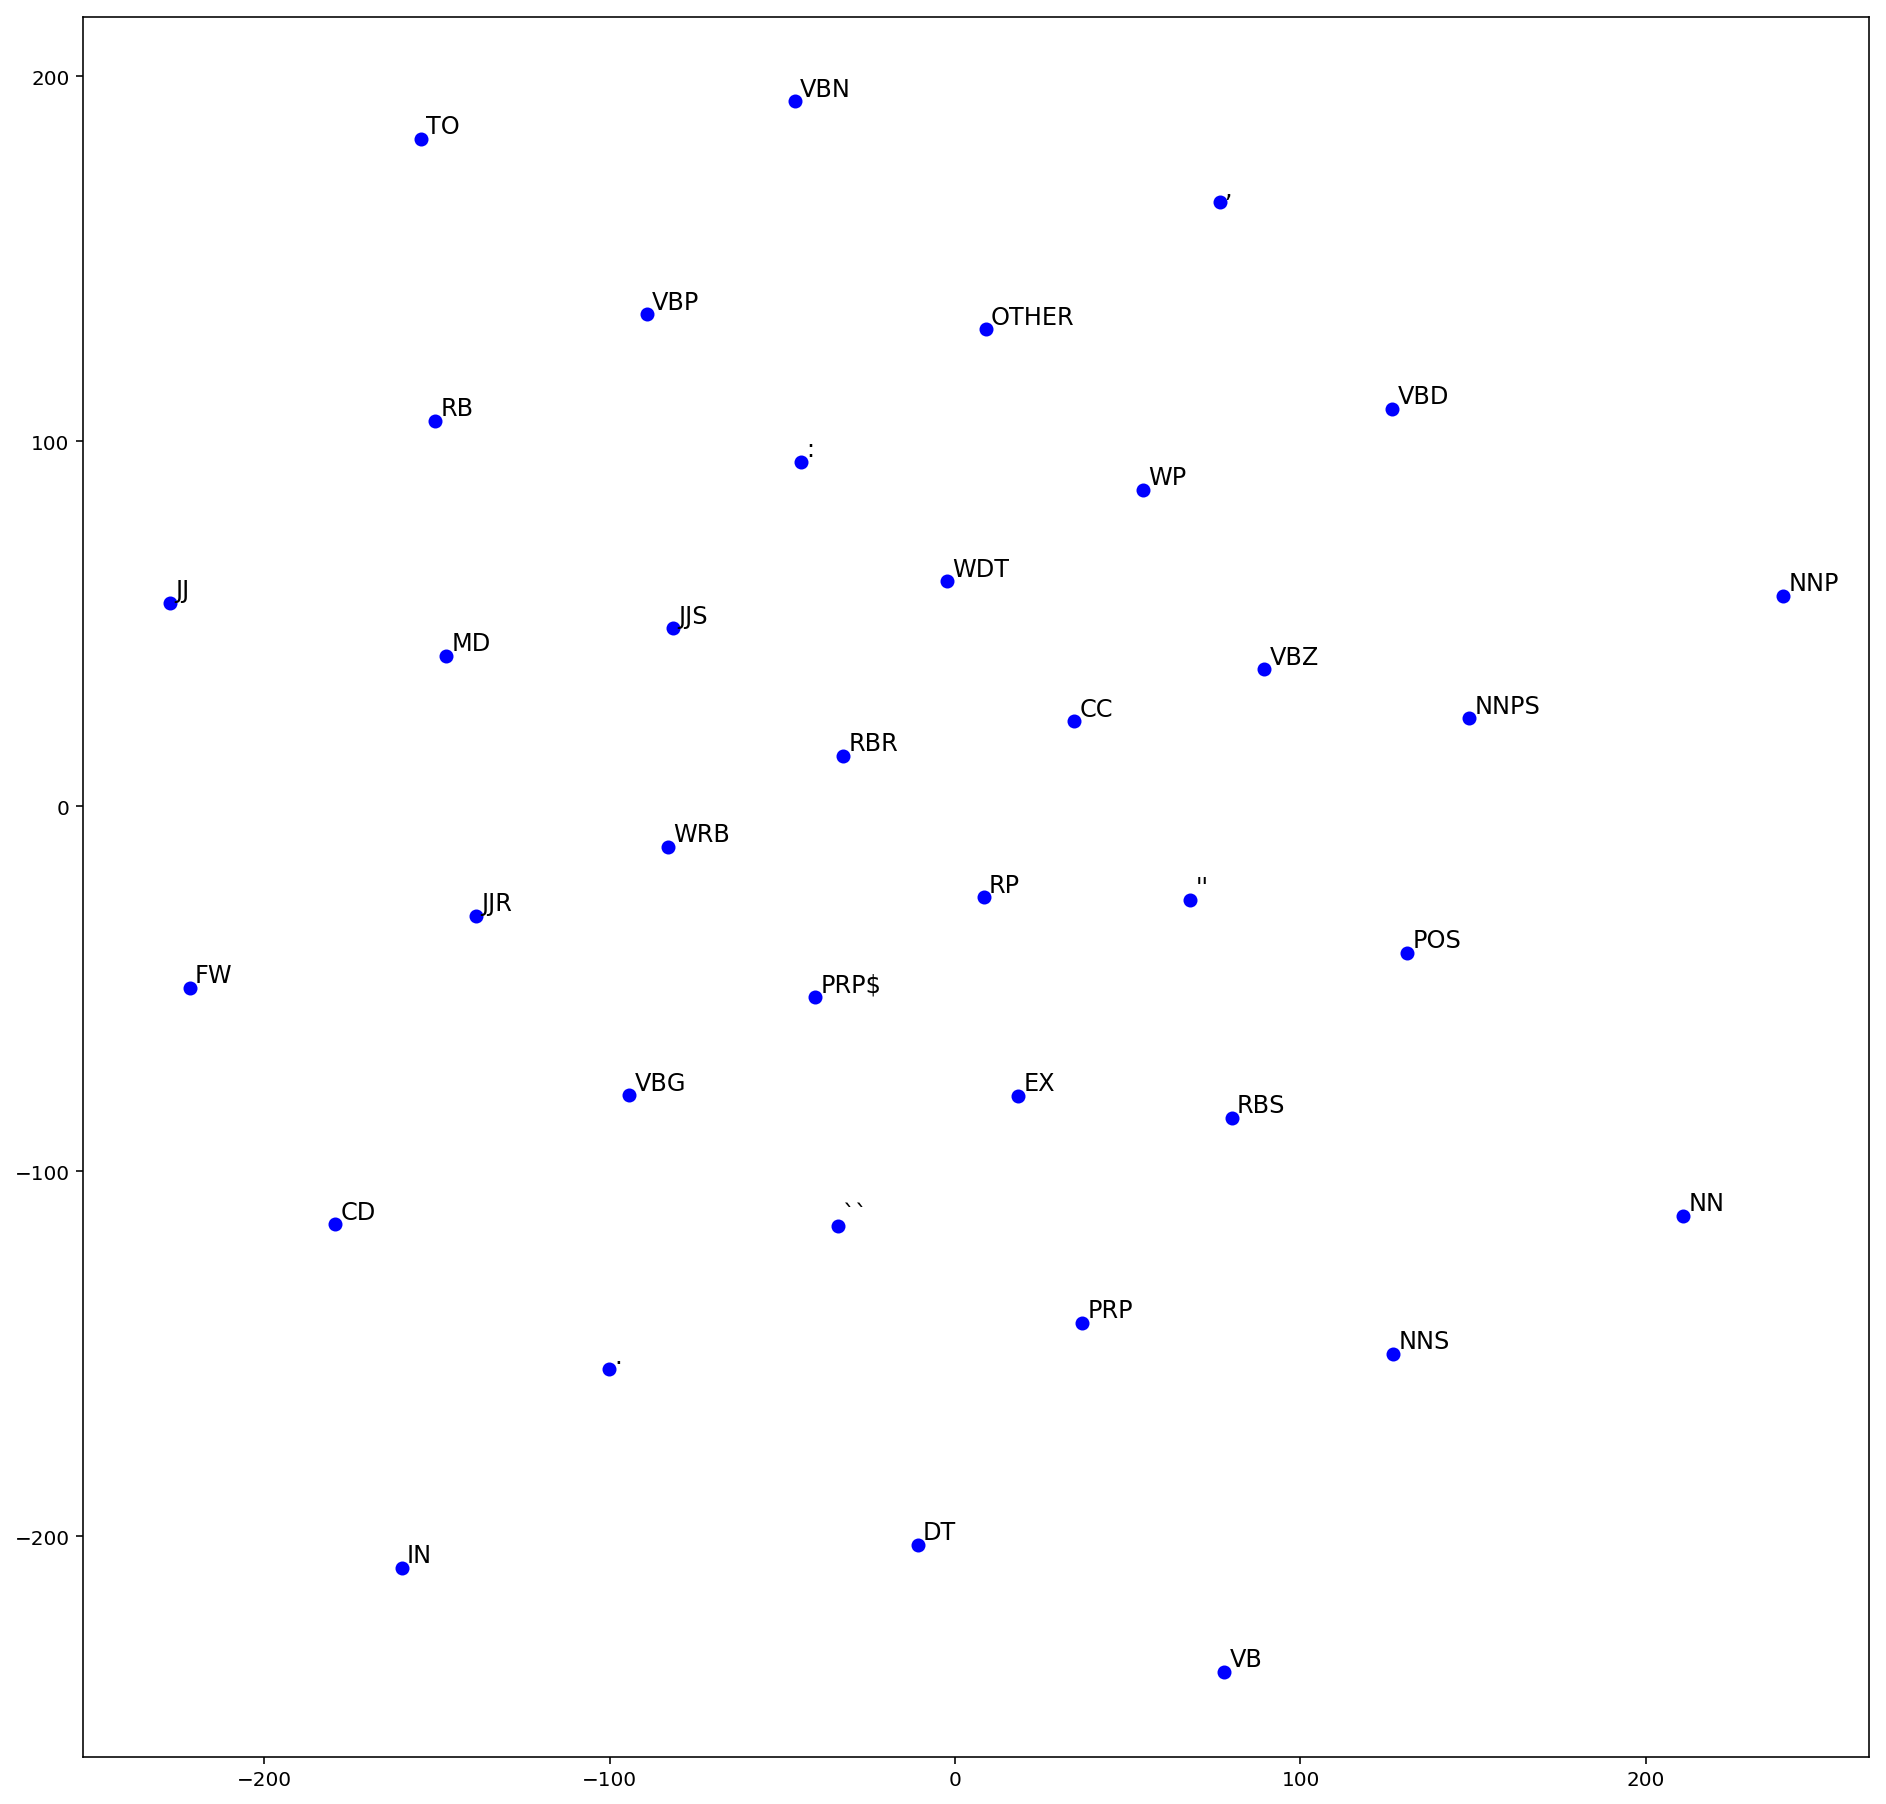

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

viz_words = n_vocab
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='blue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=1, xytext=(embed_tsne[idx, 0]+1.5, embed_tsne[idx, 1]+1.5), fontsize=12)

In [13]:
embed_mat = embed_mat.tolist() # nested lists with same data, indices


with open('data/pos_embd.json', 'w') as fh:
    json.dump(embed_mat, fh)